In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
classes_dict = {"no-mask_data":0,
                "mask_data":1}
classes = ["no-mask", "mask"]
img_width, img_height = 128, 128

In [3]:
import os
from os.path import join
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from collections import OrderedDict

dataset_path = "/content/drive/My Drive/Dataset"
img_list = []
label_list = []

for class_name in os.listdir(dataset_path):
  dir = join(dataset_path, class_name)
  with tqdm(os.listdir(dir)) as pbar:
    for i, file in enumerate(pbar):
      pbar.set_description(class_name)
      img_path = join(dir, file)
      img = Image.open(img_path)
      img = img.resize((img_width, img_height))
      img = np.array(img)
      img_list.append(img)
      label_list.append(classes_dict[class_name])
      pbar.set_postfix(OrderedDict(file=img_path))

In [0]:
from matplotlib import pyplot as plt

def show_sample(X, y, index):
  plt.imshow(X[index])
  print("label : ",end="")
  print(classes[y[index]])


In [6]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical

#Xをnp.ndarrayに,yをOne-Hotエンコーディングに変換する
X = np.array(img_list, dtype="float32")
y = to_categorical(label_list, dtype="int")

#正規化(値を0~1に変換)
X -= X.min()
X /= X.max()

Using TensorFlow backend.


In [0]:
#ホールドアウト法によりデータを分割(2割を検証用データとする)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [0]:
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Activation, Dense, Flatten, Dropout
from keras import optimizers


In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(len(classes), activation='softmax'))

vgg_model = Model(input=vgg16.input, output=top_model(vgg16.output))

for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
          metrics=['accuracy'])





58892288/58889256 [==============================] - 3s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [11]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [0]:
from keras.callbacks import EarlyStopping
batch_size = 32
n_epoch = 50
early_stopping = EarlyStopping(patience=20, verbose=0)

In [13]:

hist = vgg_model.fit(X_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=n_epoch,
                     validation_data=(X_test, y_test)
                     )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 10s 40ms/step - loss: 0.6179 - acc: 0.6875 - val_loss: 0.1923 - val_acc: 0.9500
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.1379 - acc: 0.9500 - val_loss: 0.0558 - val_acc: 0.9667
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0680 - acc: 0.9750 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0356 - acc: 0.9875 - val_loss: 0.0442 - val_acc: 0.9833
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0084 - acc: 0.9958 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0053 - acc: 0.9958 - val_loss: 0.0216 - val_acc: 0.9833
Epoch 7/50
240/240 [==============================] - 1s 3ms/step

In [0]:
def plot_history(hist, eval):
  if eval == "loss":
    plt.plot(hist.history["loss"], label="loss for training")
    plt.plot(hist.history["val_loss"], label="loss for validation")
    plt.title("model loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="best")
    plt.show()
  if eval == "acc":
    plt.plot(hist.history["acc"], label="acc for training")
    plt.plot(hist.history["val_acc"], label="acc for validation")
    plt.title("model acc")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.legend(loc="best")
    plt.show()
  else:
    print("invalid eval")

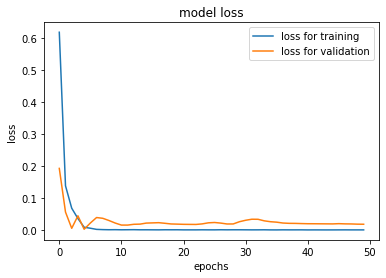

invalid eval


In [16]:
plot_history(hist, eval="loss")

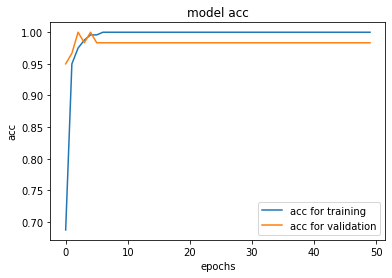

In [17]:
plot_history(hist, eval="acc")

In [18]:
from sklearn import metrics

pred = vgg_model.predict(X_test).argmax(axis=1)
y_test = y_test.argmax(axis=1)#One-Hotから復元
print('accuracy: %.3f' % metrics.accuracy_score(y_test, pred)) # 正答率
print('recall: %.3f' % metrics.recall_score(y_test, pred, average='macro')) # 再現率
print('precision: %.3f' % metrics.precision_score(y_test, pred, average='macro')) # 適合率
print('f1_score: %.3f' % metrics.f1_score(y_test, pred, average='macro')) # f値

accuracy: 0.983
recall: 0.984
precision: 0.983
f1_score: 0.983


# **PICKLE化**

In [0]:
import pickle

with open ('img_list.pickle','wb') as f:
  pickle.dump(img_list,f)
with open ('tag_list.pickle','wb') as f:
  pickle.dump(label_list,f)

In [0]:
def unpickle(file):
    # 保存されたpickleファイルを読み込み
    # 'rb'は｢読み込み専用(r)｣かつ｢バイト列(b)｣を意味する
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

# **モデル、学習結果の保存**

In [0]:
open('mask_NN.json',"w").write(vgg_model.to_json())
vgg_model.save_weights('mask_NN_weight.h5')

In [0]:
from keras.models import Sequential, model_from_json
model = model_from_json(open('mask_NN.json', 'r').read())
model.load_weights('mask_NN_weight.h5')

In [0]:
def detect_mask(img_path):
  img=Image.open(img_path)
  img = img.resize((img_width, img_height))
  img = np.array(img)
  plt.imshow(img)
  img=img.reshape([1,128,128,3])
  pred=vgg_model.predict(img)
  print(classes[pred.argmax()])

In [49]:
img=IMG[156].reshape([1,128,128,3])
pred=model.predict(img)
print(classes[pred.argmax()])

no-mask
